In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from matplotlib import rcParams

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
R0 = 2.5
tau = 8
gamma = 1/tau
beta = R0 * gamma

In [3]:
def model_with_circuit_breaker(t_span:int, 
                               y0: tuple, 
                               beta_0: float, 
                               beta_1: float, 
                               gamma: float, 
                               tau_q:float, 
                               threshold:float) -> np.array:
    
    y = np.zeros(shape=(t_span, 4))

    y[0, :] = [*y0, 0]

    circuit_breaker_start = None

    for i in range(1, t_span):
        beta = beta_0 if y[i - 1, 3]  == 0 else beta_1

        y[i, :3] = y[i - 1, :3] + (
            - beta * y[i - 1, 0] * y[i - 1, 1],
            beta * y[i - 1, 0] * y[i - 1, 1] - gamma * y[i - 1, 1],
            gamma * y[i - 1, 1]
        )

        if y[i - 1, 3] == 1:
            if i > circuit_breaker_start + tau_q:
                y[i, 3] = 0
            else:
                y[i, 3] = 1

        if y[i - 1, 3] == 0 and y[i, 1] > threshold:
            y[i, 3] = 1
            circuit_breaker_start = i

    return y

In [4]:
res_with_cb = model_with_circuit_breaker(180, (0.98, 0.02, 0.0), beta, beta/5, gamma, 14, 0.1)

In [5]:
res_without_cb = model_with_circuit_breaker(180, (0.98, 0.02, 0.0), beta, beta, gamma, 14, 0.1)

<ipython-input-6-f5ce4cb098de>:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


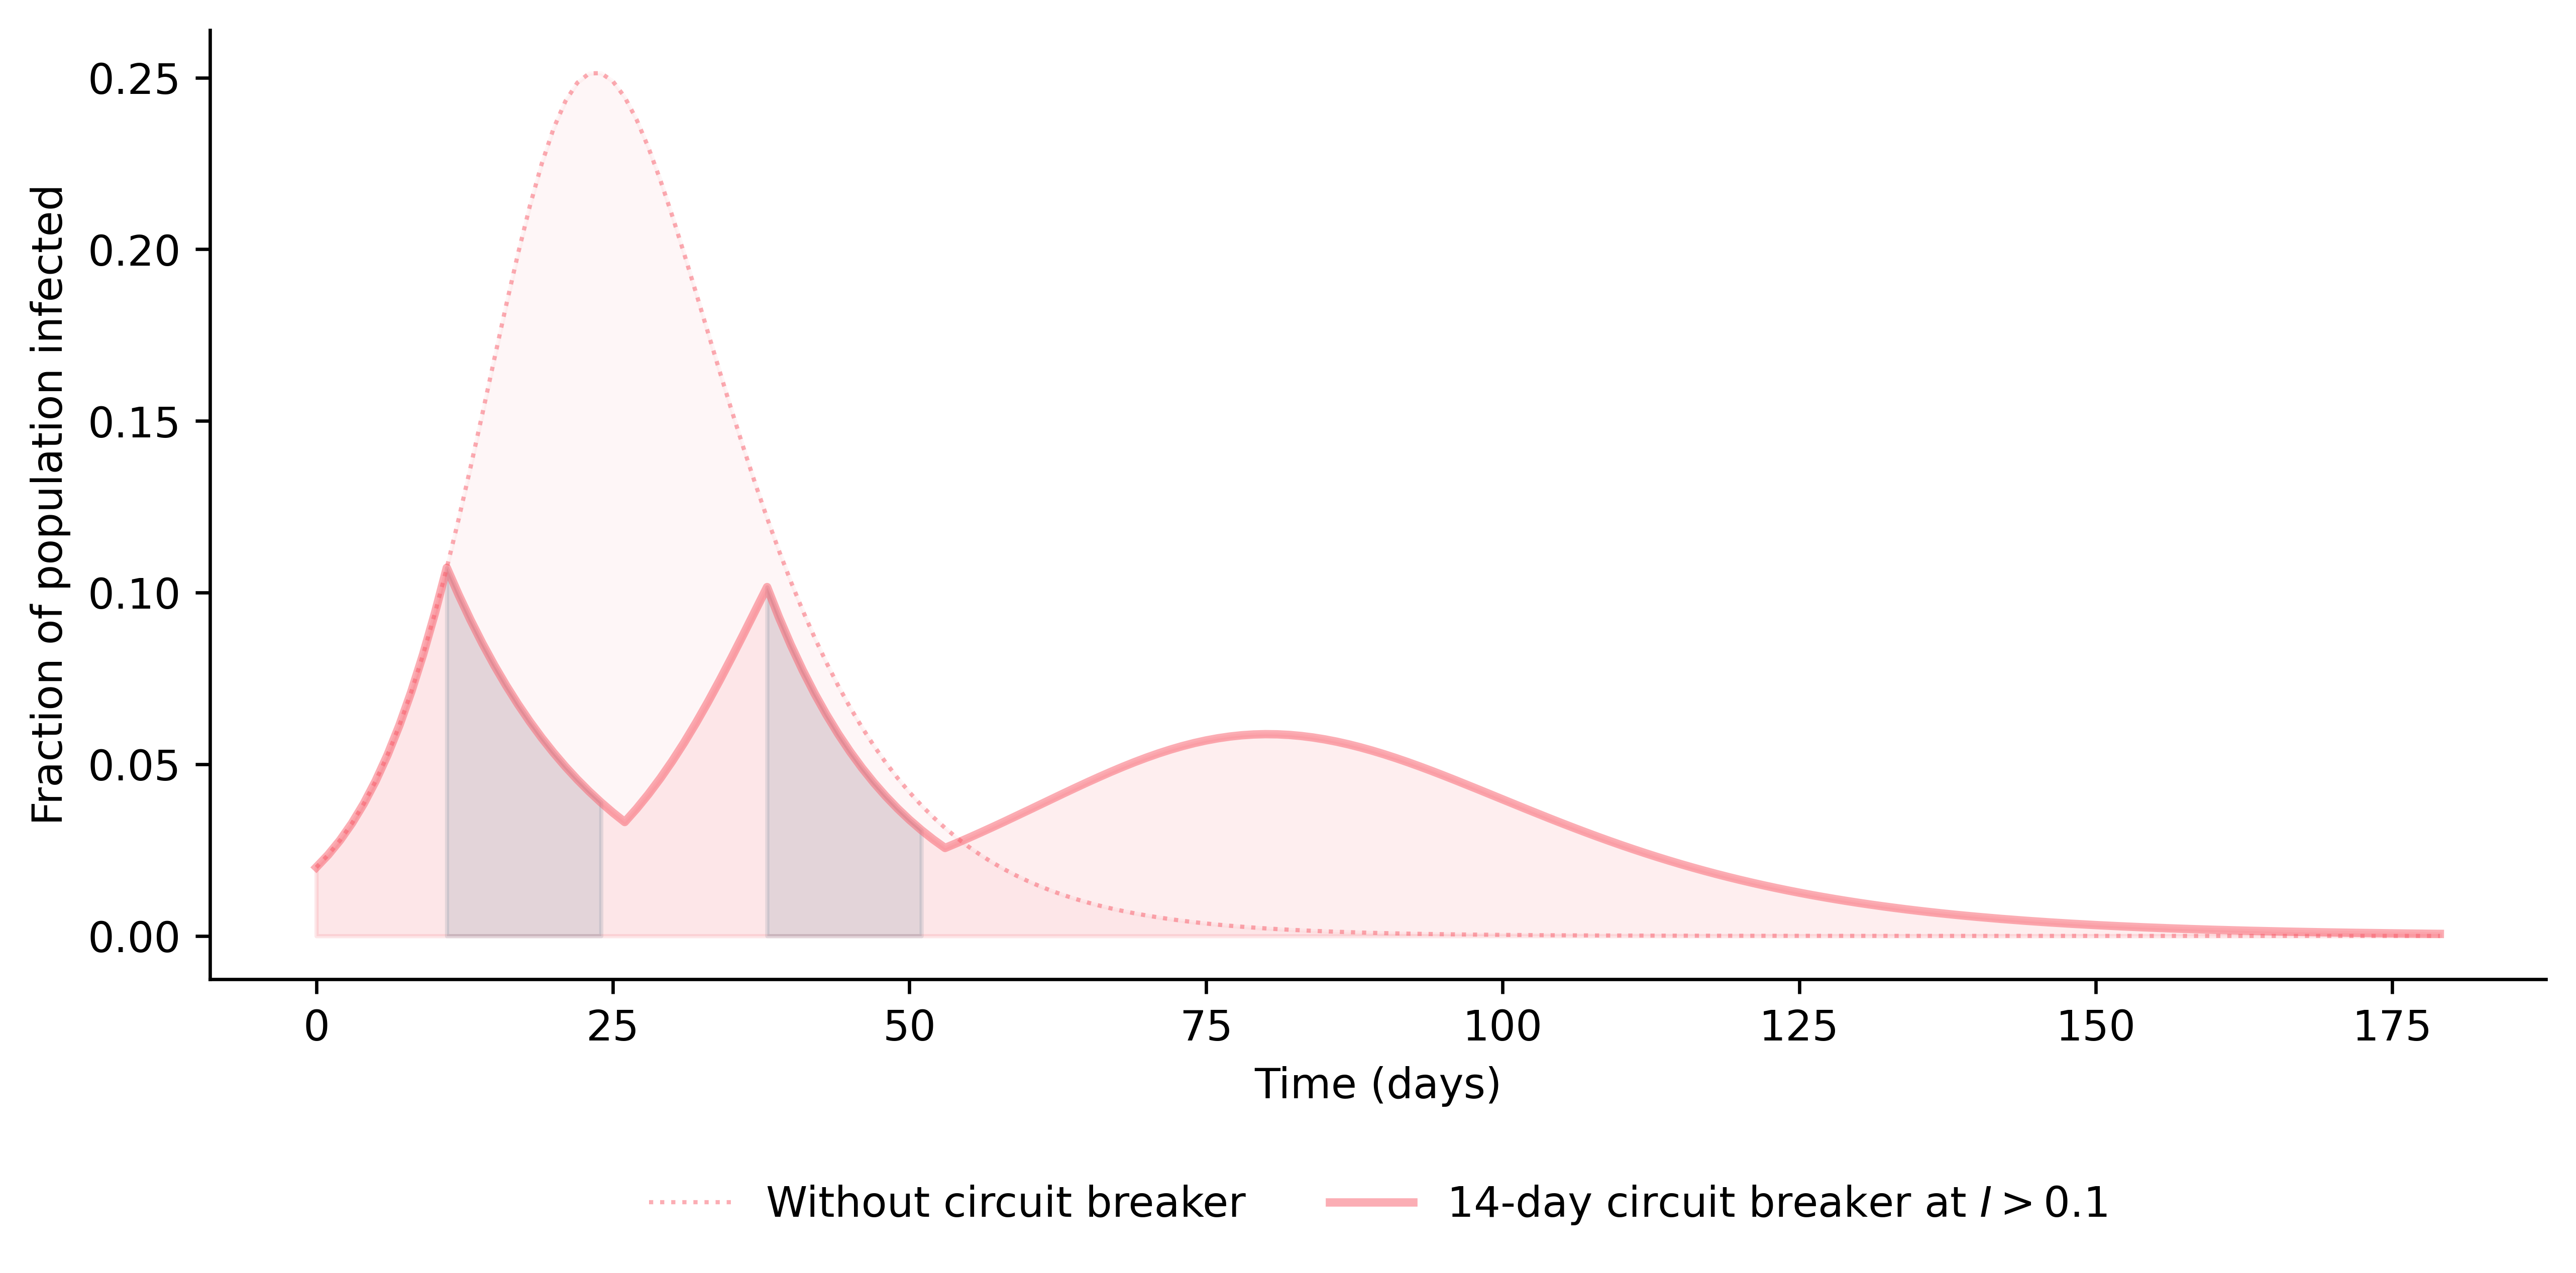

In [6]:
fig = plt.figure(facecolor="w", figsize=(10, 5), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(np.arange(0, 180), res_without_cb[:, 1], color=COLORS["I"], alpha=0.5, lw=1, label="Without circuit breaker", linestyle="dotted")
ax.plot(np.arange(0, 180), res_with_cb[:, 1], color=COLORS["I"], alpha=0.5, lw=2, label="14-day circuit breaker at $I > 0.1$")

ax.fill_between(np.arange(0, 180), 0, res_without_cb[:, 1], color=COLORS["I"], alpha=0.05)
ax.fill_between(np.arange(0, 180), 0, res_with_cb[:, 1], color=COLORS["I"], alpha=0.1)
ax.fill_between(np.arange(11, 25), 0, res_with_cb[11:25, 1], color=COLORS["D"], alpha=0.1)
ax.fill_between(np.arange(38, 52), 0, res_with_cb[38:52, 1], color=COLORS["D"], alpha=0.1)



ax.set_xlabel('Time (days)')
ax.set_ylabel("Fraction of population infected")
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title='', bbox_to_anchor=(0.5, -0.3), loc="lower center", ncol=5, frameon=False)

fig.subplots_adjust(bottom=0.25)

plt.savefig("circuit_breaker.pdf")
plt.show()